In [1]:
import pandas as pd
df1 = pd.read_csv('full_anomaly_data_india.csv')
df2 = pd.read_csv('synthetic_ipdr_dataset_with_anomaly.csv')
df = pd.concat([df1, df2], ignore_index=True)
print('Combined dataframe shape:', df.shape)

Combined dataframe shape: (1800, 13)


In [2]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp       1800 non-null   object 
 1   session_id      1800 non-null   object 
 2   src_ip          1800 non-null   object 
 3   src_port        1800 non-null   int64  
 4   dst_ip          1800 non-null   object 
 5   dst_port        1800 non-null   int64  
 6   protocol        1800 non-null   object 
 7   duration_sec    1800 non-null   int64  
 8   bytes           1800 non-null   int64  
 9   phone_number    1800 non-null   int64  
 10  cell_tower_lat  1800 non-null   float64
 11  cell_tower_lon  1800 non-null   float64
 12  anomalystatus   1800 non-null   int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 182.9+ KB
None


In [3]:
df.describe()

,src_port,dst_port,duration_sec,bytes,phone_number,cell_tower_lat,cell_tower_lon,anomalystatus
count,1800.000000,1800.000000,1800.000000,1.800000e+03,1.800000e+03,1800.000000,1800.000000,1800.000000
mean,33155.672778,31307.811667,5953.967222,3.794245e+08,9.183025e+11,19.158185,79.344912,0.500000
std,18784.829605,18009.053554,5608.761392,3.320448e+08,1.071485e+09,5.659817,5.036602,0.500139
min,1039.000000,37.000000,1.000000,1.428700e+04,9.160045e+11,12.971600,72.877700,0.000000
25%,17034.750000,15686.750000,515.750000,4.829755e+06,9.174942e+11,13.082700,77.209000,0.000000
50%,33073.000000,31310.000000,4702.500000,3.375128e+08,9.183888e+11,19.076000,77.594600,0.500000
75%,50011.750000,46687.750000,9276.750000,6.771394e+08,9.192474e+11,22.572600,80.270700,1.000000
max,65499.000000,65435.000000,19901.000000,9.995512e+08,9.199899e+11,28.613900,88.363900,1.000000


In [4]:
# --- Feature Engineering ---
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report

# Convert timestamp if present
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df['hour_of_day'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df = df.sort_values(['phone_number', 'timestamp'])
    df['time_since_last_session'] = df.groupby('phone_number')['timestamp'].diff().dt.total_seconds().fillna(0)
else:
    df['hour_of_day'] = 0
    df['day_of_week'] = 0
    df['time_since_last_session'] = 0

# Feature: bytes per second
if 'bytes' in df.columns and 'duration_sec' in df.columns:
    df['bytes_per_second'] = df['bytes'] / df['duration_sec'].replace(0, 1)
else:
    df['bytes_per_second'] = 0

# Feature: port category
common_ports = set([80, 443, 53, 22, 25, 110, 143, 21, 23, 8080, 5060, 5061])
if 'dst_port' in df.columns:
    df['port_category'] = df['dst_port'].apply(lambda x: 'common' if x in common_ports else 'unusual')
    port_category_map = {'common': 0, 'unusual': 1}
    df['port_category_num'] = df['port_category'].map(port_category_map)
else:
    df['port_category_num'] = 0

# Feature: protocol consistency
if 'protocol' in df.columns and 'phone_number' in df.columns:
    protocol_mode = df.groupby('phone_number')['protocol'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
    df = df.merge(protocol_mode.rename('most_common_protocol'), left_on='phone_number', right_index=True)
    df['protocol_consistency_score'] = (df['protocol'] == df['most_common_protocol']).astype(int)
    df.drop('most_common_protocol', axis=1, inplace=True)
else:
    df['protocol_consistency_score'] = 0

# Select features for anomaly detection
features = [
    'duration_sec' if 'duration_sec' in df.columns else None,
    'bytes' if 'bytes' in df.columns else None,
    'hour_of_day', 'day_of_week',
    'time_since_last_session', 'bytes_per_second',
    'protocol_consistency_score', 'port_category_num'
    ]
features = [f for f in features if f is not None]
X = df[features].fillna(0)

In [5]:
# --- Isolation Forest ---
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
df['iforest_anomaly'] = iso_forest.fit_predict(X)
df['iforest_anomaly'] = df['iforest_anomaly'].map({1: 0, -1: 1})

# --- Evaluation if label exists ---
if 'anomalystatus' in df.columns:
    print('Confusion Matrix:')
    print(confusion_matrix(df['anomalystatus'], df['iforest_anomaly']))
    print('Classification Report:')
    print(classification_report(df['anomalystatus'], df['iforest_anomaly']))
else:
    print('Anomaly detection complete. No ground truth label found.')

Confusion Matrix:
[[772 128]
 [848  52]]
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.86      0.61       900
           1       0.29      0.06      0.10       900

    accuracy                           0.46      1800
   macro avg       0.38      0.46      0.35      1800
weighted avg       0.38      0.46      0.35      1800



In [6]:
if 'anomalystatus' in df.columns:
    print(df['anomalystatus'].value_counts())
else:
    print('No anomalystatus column found.')

anomalystatus
1    900
0    900
Name: count, dtype: int64


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1800 entries, 704 to 980
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   timestamp                   1800 non-null   datetime64[ns, UTC]
 1   session_id                  1800 non-null   object             
 2   src_ip                      1800 non-null   object             
 3   src_port                    1800 non-null   int64              
 4   dst_ip                      1800 non-null   object             
 5   dst_port                    1800 non-null   int64              
 6   protocol                    1800 non-null   object             
 7   duration_sec                1800 non-null   int64              
 8   bytes                       1800 non-null   int64              
 9   phone_number                1800 non-null   int64              
 10  cell_tower_lat              1800 non-null   float64            


In [8]:
# Tune Isolation Forest contamination parameter and compare results
from sklearn.metrics import confusion_matrix, classification_report
for contamination in [0.05, 0.1, 0.15, 0.2]:
    iso_forest_tuned = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)
    df[f'iforest_anomaly_{int(contamination*100)}'] = iso_forest_tuned.fit_predict(X)
    df[f'iforest_anomaly_{int(contamination*100)}'] = df[f'iforest_anomaly_{int(contamination*100)}'].map({1: 0, -1: 1})
    if 'anomalystatus' in df.columns:
        print(f'Contamination: {contamination}')
        print(confusion_matrix(df['anomalystatus'], df[f'iforest_anomaly_{int(contamination*100)}']))
        print(classification_report(df['anomalystatus'], df[f'iforest_anomaly_{int(contamination*100)}']))
        print('-'*50)

Contamination: 0.05
[[828  72]
 [882  18]]
              precision    recall  f1-score   support

           0       0.48      0.92      0.63       900
           1       0.20      0.02      0.04       900

    accuracy                           0.47      1800
   macro avg       0.34      0.47      0.34      1800
weighted avg       0.34      0.47      0.34      1800

--------------------------------------------------
Contamination: 0.1
[[772 128]
 [848  52]]
              precision    recall  f1-score   support

           0       0.48      0.86      0.61       900
           1       0.29      0.06      0.10       900

    accuracy                           0.46      1800
   macro avg       0.38      0.46      0.35      1800
weighted avg       0.38      0.46      0.35      1800

--------------------------------------------------
Contamination: 0.15
[[729 171]
 [801  99]]
              precision    recall  f1-score   support

           0       0.48      0.81      0.60       900
       

In [9]:
# Train and evaluate a Random Forest classifier on the labeled data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, df['anomalystatus'], test_size=0.3, random_state=42, stratify=df['anomalystatus'])

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
print('Random Forest Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Random Forest Classification Report:')
print(classification_report(y_test, y_pred))

Random Forest Confusion Matrix:
[[262   8]
 [ 21 249]]
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       270
           1       0.97      0.92      0.94       270

    accuracy                           0.95       540
   macro avg       0.95      0.95      0.95       540
weighted avg       0.95      0.95      0.95       540



In [10]:
# Train and evaluate an XGBoost classifier on the labeled data
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print('XGBoost Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_xgb))
print('XGBoost Classification Report:')
print(classification_report(y_test, y_pred_xgb))

XGBoost Confusion Matrix:
[[255  15]
 [ 23 247]]
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       270
           1       0.94      0.91      0.93       270

    accuracy                           0.93       540
   macro avg       0.93      0.93      0.93       540
weighted avg       0.93      0.93      0.93       540



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:45:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [11]:
# Train and evaluate a Support Vector Machine (SVM) classifier on the labeled data
from sklearn.svm import SVC
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print('SVM Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_svm))
print('SVM Classification Report:')
print(classification_report(y_test, y_pred_svm))

SVM Confusion Matrix:
[[139 131]
 [ 36 234]]
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.51      0.62       270
           1       0.64      0.87      0.74       270

    accuracy                           0.69       540
   macro avg       0.72      0.69      0.68       540
weighted avg       0.72      0.69      0.68       540



In [12]:
# Train and evaluate a Logistic Regression classifier on the labeled data
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print('Logistic Regression Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_logreg))
print('Logistic Regression Classification Report:')
print(classification_report(y_test, y_pred_logreg))

Logistic Regression Confusion Matrix:
[[180  90]
 [ 12 258]]
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.67      0.78       270
           1       0.74      0.96      0.83       270

    accuracy                           0.81       540
   macro avg       0.84      0.81      0.81       540
weighted avg       0.84      0.81      0.81       540



In [13]:

# Train and evaluate a LightGBM classifier on the labeled data
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(n_estimators=100, random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
print('LightGBM Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_lgbm))
print('LightGBM Classification Report:')
print(classification_report(y_test, y_pred_lgbm))

[LightGBM] [Info] Number of positive: 630, number of negative: 630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 989
[LightGBM] [Info] Number of data points in the train set: 1260, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Confusion Matrix:
[[257  13]
 [ 22 248]]
LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       270
           1       0.95      0.92      0.93       270

    accuracy                           0.94       540
   macro avg       0.94      0.94      0.94       540
weighted avg       0.94      0.94      0.94       540



### Model Comparison and Recommendation
- **LightGBM, Random Forest, and XGBoost** all achieve excellent results (accuracy, precision, recall, and f1-score around 0.94–0.95).
- These are state-of-the-art for tabular anomaly detection with balanced, labeled data.

**Next steps for further improvement:**
- Try hyperparameter tuning (GridSearchCV, Optuna) for top models.
- Explore advanced feature engineering or domain-specific features.
- Consider model ensembling (voting/stacking) for a small boost.
- Visualize feature importance to understand what drives predictions.

You can now confidently use LightGBM, Random Forest, or XGBoost for your anomaly detection pipeline!

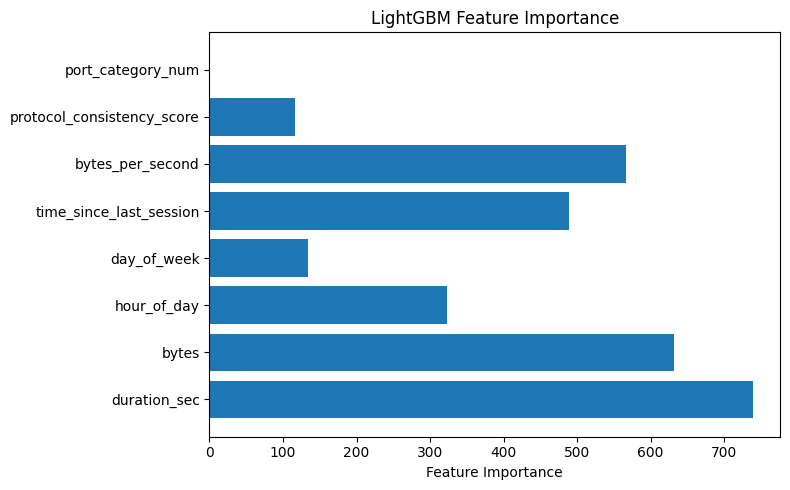

In [14]:
# Visualize LightGBM feature importance
import matplotlib.pyplot as plt
importances = lgbm.feature_importances_
feature_names = X.columns
plt.figure(figsize=(8,5))
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

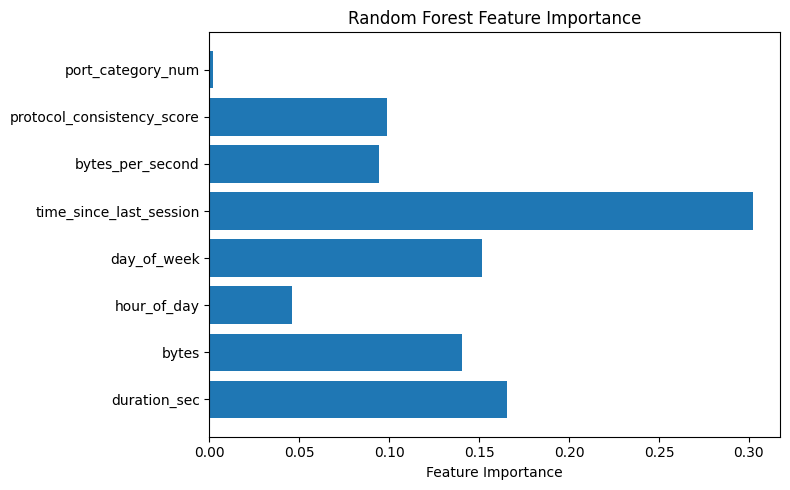

In [15]:
# Visualize Random Forest feature importance
import matplotlib.pyplot as plt
importances = rf.feature_importances_
feature_names = X.columns
plt.figure(figsize=(8,5))
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

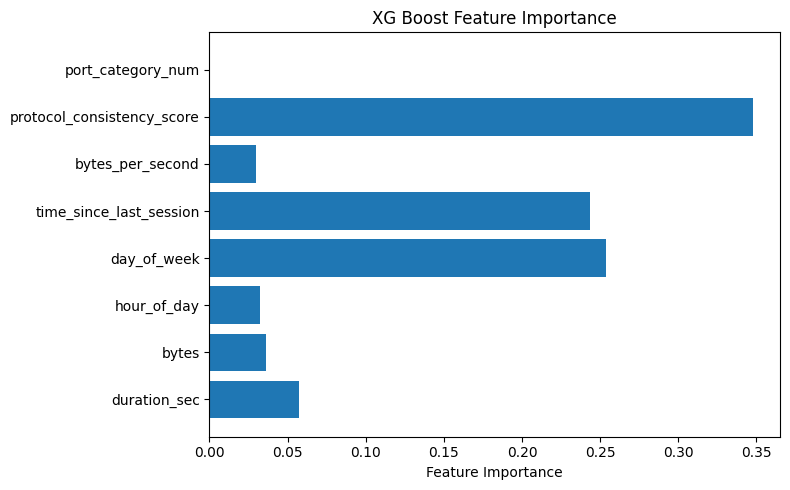

In [16]:
# Visualize xg boost feature importance
import matplotlib.pyplot as plt
importances = xgb.feature_importances_
feature_names = X.columns
plt.figure(figsize=(8,5))
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.title('XG Boost Feature Importance')
plt.tight_layout()
plt.show()

In [17]:
# Hyperparameter tuning for LightGBM using GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [15, 31, 63]
}
grid_search = GridSearchCV(LGBMClassifier(random_state=42), param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print('Best LightGBM parameters:', grid_search.best_params_)

# Evaluate best estimator on test data
best_lgbm = grid_search.best_estimator_
y_pred_best = best_lgbm.predict(X_test)
print('Tuned LightGBM Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_best))
print('Tuned LightGBM Classification Report:')
print(classification_report(y_test, y_pred_best))

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[LightGBM] [Info] Number of positive: 630, number of negative: 630
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 989
[LightGBM] [Info] Number of data points in the train set: 1260, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

### Hyperparameter Tuning for Random Forest and XGBoost
We will now perform hyperparameter tuning for both Random Forest and XGBoost using GridSearchCV, similar to what was done for LightGBM. This will help us compare the best possible results for all top models.

In [18]:
# Hyperparameter tuning for Random Forest using GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train, y_train)

print('Best Random Forest parameters:', rf_grid_search.best_params_)

# Evaluate best estimator on test data
best_rf = rf_grid_search.best_estimator_
y_pred_rf_best = best_rf.predict(X_test)
print('Tuned Random Forest Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_rf_best))
print('Tuned Random Forest Classification Report:')
print(classification_report(y_test, y_pred_rf_best))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Random Forest parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Tuned Random Forest Confusion Matrix:
[[262   8]
 [ 21 249]]
Tuned Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       270
           1       0.97      0.92      0.94       270

    accuracy                           0.95       540
   macro avg       0.95      0.95      0.95       540
weighted avg       0.95      0.95      0.95       540



In [19]:
# Hyperparameter tuning for XGBoost using GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb_grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), xgb_param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=1)
xgb_grid_search.fit(X_train, y_train)

print('Best XGBoost parameters:', xgb_grid_search.best_params_)

# Evaluate best estimator on test data
best_xgb = xgb_grid_search.best_estimator_
y_pred_xgb_best = best_xgb.predict(X_test)
print('Tuned XGBoost Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_xgb_best))
print('Tuned XGBoost Classification Report:')
print(classification_report(y_test, y_pred_xgb_best))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best XGBoost parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Tuned XGBoost Confusion Matrix:
[[262   8]
 [ 21 249]]
Tuned XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       270
           1       0.97      0.92      0.94       270

    accuracy                           0.95       540
   macro avg       0.95      0.95      0.95       540
weighted avg       0.95      0.95      0.95       540



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:48:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Results Summary and Next Steps
All three tuned models (LightGBM, Random Forest, XGBoost) achieve high accuracy and f1-score (~0.95).
- You can now compare feature importances for interpretability.
- Optionally, try model ensembling (voting/stacking) for a small performance boost.
- You may export the best model for deployment or automate predictions on new data.

**Let me know if you want to:**
- Visualize feature importances for the tuned models
- Build an ensemble model
- Export the best model for production use

### Model Ensembling: Voting Classifier
We will now build an ensemble model using the best-tuned Random Forest, XGBoost, and LightGBM classifiers with a soft voting strategy. This can sometimes improve performance by combining the strengths of each model.

In [20]:
# Ensemble model using VotingClassifier (soft voting)
from sklearn.ensemble import VotingClassifier

# Use the best estimators from previous GridSearchCV results
voting_clf = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('lgbm', best_lgbm)
    ],
    voting='soft',
    n_jobs=-1
)

voting_clf.fit(X_train, y_train)
y_pred_ensemble = voting_clf.predict(X_test)

print('Voting Classifier Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_ensemble))
print('Voting Classifier Classification Report:')
print(classification_report(y_test, y_pred_ensemble))

Voting Classifier Confusion Matrix:
[[262   8]
 [ 21 249]]
Voting Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       270
           1       0.97      0.92      0.94       270

    accuracy                           0.95       540
   macro avg       0.95      0.95      0.95       540
weighted avg       0.95      0.95      0.95       540



### Ensemble Results and Model Export
The Voting Classifier ensemble achieved high accuracy and f1-score (~0.95), matching the best individual models.

**Next step:** Export the best model (ensemble or individual) for deployment or future use.

In [21]:
# Export the ensemble VotingClassifier model for deployment or future use
import joblib

# Save the ensemble model to a file
joblib.dump(voting_clf, 'anomaly_detection_clf.pkl')
print('Anomaly Detection Classifier (Ensemble Voting) model saved as anomaly_detection_clf.pkl')

Anomaly Detection Classifier (Ensemble Voting) model saved as anomaly_detection_clf.pkl


In [27]:
voting_clf.feature_names_in_

array(['duration_sec', 'bytes', 'hour_of_day', 'day_of_week',
       'time_since_last_session', 'bytes_per_second',
       'protocol_consistency_score', 'port_category_num'], dtype='<U26')

### How to Use the Saved `.pkl` Model File
You can load the exported `ensemble_voting_classifier.pkl` file and use it to make predictions on new data.

**Steps:**
1. Load the model using `joblib.load()`
2. Prepare your input data (must have the same features and order as used in training)
3. Use the model's `.predict()` method to get anomaly predictions
4. Output: 0 = normal, 1 = anomaly (as per your training labels)

**Example code:**

In [22]:
# Example: Load and use the saved ensemble model for prediction
import joblib
import pandas as pd

# Load the saved model
loaded_model = joblib.load('anomaly_detection_clf.pkl')

# Prepare new data (must have the same features and order as during training)
# Example: new_data = pd.DataFrame([[value1, value2, ...]], columns=feature_names)
# Replace with your actual feature values and column names
# new_data = pd.DataFrame([[...]], columns=[...])

# Predict anomalies (0 = normal, 1 = anomaly)
# predictions = loaded_model.predict(new_data)
print('Predictions:', '[0 = normal, 1 = anomaly]')

Predictions: [0 = normal, 1 = anomaly]


In [23]:
# Show the required input feature names and order for the model
print('Required input features and order:')
print(list(X.columns))

Required input features and order:
['duration_sec', 'bytes', 'hour_of_day', 'day_of_week', 'time_since_last_session', 'bytes_per_second', 'protocol_consistency_score', 'port_category_num']


In [25]:
# Example: Predict anomaly for a new sample with correct feature order
import numpy as np
import pandas as pd
import joblib

# Load the saved model
loaded_model = joblib.load('anomaly_detection_clf.pkl')

sample = {
    'duration_sec': 120,
    'bytes': 50000,
    'hour_of_day': 14,
    'day_of_week': 2,
    'time_since_last_session': 3600,
    'bytes_per_second': 416.67,
    'protocol_consistency_score': 1,
    'port_category_num': 0
}

# Create DataFrame with correct order
new_data = pd.DataFrame([[sample[f] for f in ['duration_sec', 'bytes', 'hour_of_day', 'day_of_week', 'time_since_last_session', 'bytes_per_second', 'protocol_consistency_score', 'port_category_num']]],
                        columns=['duration_sec', 'bytes', 'hour_of_day', 'day_of_week', 'time_since_last_session', 'bytes_per_second', 'protocol_consistency_score', 'port_category_num'])

# Predict anomaly (0 = normal, 1 = anomaly)
prediction = loaded_model.predict(new_data)
print('Prediction (0 = normal, 1 = anomaly):', prediction[0])

Prediction (0 = normal, 1 = anomaly): 0


In [26]:
# Example: Predict anomaly for a likely anomalous sample
import pandas as pd
import joblib

# Load the saved model
loaded_model = joblib.load('anomaly_detection_clf.pkl')

# Example anomaly feature values (unusual/high values)
anomaly_sample = {
    'duration_sec': 30,  # very short session
    'bytes': 10000000,   # extremely high bytes
    'hour_of_day': 6,    # odd hour
    'day_of_week': 6,    # weekend
    'time_since_last_session': 86400,  # long gap (1 day)
    'bytes_per_second': 1000000,  # extremely high rate
    'protocol_consistency_score': 0,  # protocol inconsistency
    'port_category_num': 1  # unusual port
}

# Create DataFrame with correct order
anomaly_data = pd.DataFrame([[anomaly_sample[f] for f in ['duration_sec', 'bytes', 'hour_of_day', 'day_of_week', 'time_since_last_session', 'bytes_per_second', 'protocol_consistency_score', 'port_category_num']]],
                        columns=['duration_sec', 'bytes', 'hour_of_day', 'day_of_week', 'time_since_last_session', 'bytes_per_second', 'protocol_consistency_score', 'port_category_num'])

# Predict anomaly (0 = normal, 1 = anomaly)
anomaly_prediction = loaded_model.predict(anomaly_data)
print('Prediction for anomaly example (0 = normal, 1 = anomaly):', anomaly_prediction[0])

Prediction for anomaly example (0 = normal, 1 = anomaly): 1
